In [ ]:
from google.colab import drive
drive.mount('/content/BARelevantData')

Mounted at /content/BARelevantData


In [ ]:
%pip install rdflib
%pip install SPARQLWrapper
%pip install html
import rdflib
import html
from SPARQLWrapper import SPARQLWrapper, JSON
g = rdflib.Graph().parse('/content/BARelevantData/MyDrive/BARelevantData/data/fb15k-wikitop2021-yago-facts.nt', format='ntriples')
g += rdflib.Graph().parse('/content/BARelevantData/MyDrive/BARelevantData/data/fb15k-wikitop2021-yago-full-types.nt', format='ntriples')

from rdflib.namespace import RDF
for line in open('/content/BARelevantData/MyDrive/BARelevantData/data/fb15k-wikitop2021.tsv').readlines()[1:]:
    subject = rdflib.URIRef( line.split('\t')[6][1:-1] ) # take the URI in column 6
    g.add( (subject, RDF.type, rdflib.URIRef('http://example.com/popularEntity')) )

g.remove((None, rdflib.URIRef('http://schema.org/image') , None))
g.remove((None, rdflib.URIRef('http://schema.org/url') , None))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


<Graph identifier=Neb34bf7bec9745d69422fcdb558c5c1c (<class 'rdflib.graph.Graph'>)>

In [ ]:
subject='http://yago-knowledge.org/resource/David_Bowie'
attributes=[]
query = f"""
select  ?p ?o
where {{
<{subject}> ?p ?o .}}"""

results = g.query(query)
for b in results:
    attributes.append(f'{subject}, {b.p}, {b.o}')
#print(attributes)

In [ ]:
query = f"""
SELECT ?s ?p ?o
WHERE {{
?s ?p ?o .
    FILTER(?s = <http://yago-knowledge.org/resource/David_Bowie>)
    FILTER(?p = <http://schema.org/alumniOf>)
    FILTER(?o = <http://yago-knowledge.org/resource/Ravensbourne_University_London>)
    }}
    """
results=g.query(query)
print(len(results)>0)


True


In [ ]:
#from the query results extract a list that contains the counts after splitting on certain attributes
import re
PosAttr=['?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .', '?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.']
NegAttr=[]
AttrHistory = ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']

def prepareProps(popEntities):
    Distribution = {}
    for i in popEntities:
        Distribution[i]= 1/len(popEntities)
    return Distribution


def extractCountAndAttr(result):
    number = []
    listOfObj = []
    listOfPred= []
    for attr in result["results"]["bindings"]:
        listOfObj.append(attr['o'])
        listOfPred.append(attr['p'])
    #print(listOfObj[0])
    return(listOfObj,listOfPred)



def updateQuery(left, PosFilters, NegFilters):
    FilterQuestion =  (f"""
            select (count(*) as ?count) ?p ?o  where
            {{
            {PosFilters}
             ?s ?p ?o .
            {NegFilters}
            }}
            group by ?p ?o
            ORDER BY ABS( {left/2} - ?count )
            """)

    return FilterQuestion

In [ ]:

def numberleft_disable(PosFilters,NegFilters):
    query =  f"""
            select (count(?s) as ?count) where
            {{
            ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .
            ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.
            {PosFilters}{NegFilters}
          }}
            group by ?p ?o
            ORDER BY DESC(?count )
            """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    qres = sparql.query().convert()
    for r in qres["results"]["bindings"]:
        left= (r["count"]["value"])
        return(int(left))

def popentities(PosFilters,NegFilters):
    query =  f"""
            select ?s where
            {{
            ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .
            ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.
            {PosFilters}
            {NegFilters}
            }}
            """
    results = g.query(query)
    ents=[]
    for b in results:
        ents.append(f'{b.s}')
    return ents


In [ ]:
def prepareProps(popEntities):
    Distribution = {}
    for i in popEntities:
        Distribution[i] = 1
        #Distribution[i]= 1/len(popEntities)
    return Distribution


def findPosAndNeg(listOfObj, listOfPred, index):
    Filter = '?s <' + str(listOfPred[index]) +'> <'+str(listOfObj[index])+ '>.'
    negFilter='FILTER NOT EXISTS {{ \n ?s <' + str(listOfPred[index]) +'> <'+str(listOfObj[index])+ '>. }}'
    EntitiesPositive = popentities(Filter, "")
    EntitiesNegative = popentities("", negFilter)
    return (EntitiesPositive, EntitiesNegative)


def findSplits():
    possibleObj=[]
    possiblePred =[]
    count = []
    query =  f"""
            select (count(?s) as ?count)   ?o ?p
            {{
        ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .
        ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.
        ?s ?p ?o.
            }}
        group by  ?o ?p
        ORDER BY desc ( ?count )
            """
    results = g.query(query)
    count=[]
    possibleObj=[]
    possiblePred=[]
    for b in results:
        count.append(f'{b.count}')
        possibleObj.append(f'{b.o}')
        possiblePred.append(f'{b.p}')
    return (possibleObj, possiblePred, count)

def determineBestSplit(possibleObj, possiblePred, count):
    bestSplit=-1
    indexBestSplit = -1
    #branches = range(2,250)
    #for i in random.sample(branches, 40):
    for i in range(350):
        #Fix The nummerical thing here::: (skip over i if nummer)
        if str('<' + str(possiblePred[i]) +'> <'+str(possibleObj[i])+ '>') in AttrHistory:
            continue
        else:
            Yes = pos.get(str('<' + str(possiblePred[i]) +'> <'+str(possibleObj[i])+ '>'))
            No = negs.get(str('<' + str(possiblePred[i]) +'> <'+str(possibleObj[i])+ '>'))
            OccurenceYes = len(Yes)
            OccurenceNo=len(No)
            """Yes, No = findPosAndNeg(possibleObj, possiblePred, i)
            OccurenceYes=len(Yes)
            OccurenceNo=len(No)"""
            WeightYes=0
            WeightNo=0
            for y in Yes:
                WeightYes+=Distribution[y]
            for n in No:
                WeightNo+=Distribution[n]
            SumWeights=WeightYes+WeightNo
            ProbabilityYes=WeightYes/SumWeights
            ProbabilityNo=WeightNo/SumWeights
            Entropy = - (ProbabilityYes * math.log(ProbabilityYes+0.0001,2) + ProbabilityNo * math.log(ProbabilityNo+0.0001,2))
            #print(str(possiblePred[i]) +'> <'+str(possibleObj[i]), Entropy)
            if Entropy > bestSplit:
                bestSplit=Entropy
                indexBestSplit=i
    #print(bestSplit, possibleObj[indexBestSplit], possiblePred[indexBestSplit])
    return(indexBestSplit, bestSplit)

def WrongAnswerRate(answer, chance):
    if randint(0,100)<chance:
        #print("haha fooled!")
        if answer:
            answer=False
        else:
            answer=True
    return(answer)

def wrongAnswerList( amount):
    l = []
    i = -1
    for i in range(20-amount):
        l.append(True)
    for i in range(amount):
        l.append(False)
    random.shuffle(l)
    return(l, i)

def retrieveAnswer(answer, l, i):
    i+=1
    if l[i]:
        return(answer, i)
    else:
        #print("wrong answer incoming")
        return(not answer, i)
"""preparePops
enter loop
find splits, determine best split, generate question (update probabilities)"""





'preparePops\nenter loop\nfind splits, determine best split, generate question (update probabilities)'

In [ ]:
def generateHumanQuestion(listOfObj, listOfPred, index, subject, Distribution):

    AttrHistory.append('<' + str(listOfPred[index]) +'> <'+str(listOfObj[index])+ '>')
    answer = input(f'Does the thing you are looking for have the attribute: {listOfPred[index].split("/")[-1]} {listOfObj[index].split("/")[-1]}?' )

    Yes, No = findPosAndNeg(listOfObj, listOfPred, index)
    if answer.startswith('y'):
        for y in Yes:
            Distribution[y]= Distribution[y]*0.8
        for n in No:
            Distribution[n]= Distribution[n]*0.2

    else:
        for y in Yes:
            Distribution[y] = Distribution[y]*0.2
        for n in No:
            Distribution[n] = Distribution[n]*0.8

    #print(Distribution[subject])
    return Distribution

def allSubjects(qres, ind):
    attributes=[]
    subject=qres[ind]
    query = f"""
    select  ?p ?o
    where {{
    <{subject}> ?p ?o .}}"""
    results = g.query(query)
    for b in results:
        attributes.append(f'{subject}, {b.p}, {b.o}')
    return(subject, attributes)

def loadSubjects():

    query = f"""
    select distinct ?s
    where {{
        ?s ?p ?o .
        ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .
        ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.
    }}
    """
    results = g.query(query)
    ents=[]
    for b in results:
        ents.append(f'{b.s}')
    return ents

def pickSubject(qres):
    ind=randint(0,134)
    pick = qres[ind]
    return pick
    """for r in qres["results"]["bindings"][ind:ind+1]:
        return("<"+r["s"]["value"]+">")"""

def findAnswer(subject,p,o):
    query = f"""
        SELECT ?s ?p ?o
        WHERE {{
        ?s ?p ?o .
            FILTER(?s = <{subject}>)
            FILTER(?p = <{p}>)
            FILTER(?o = <{o}>)
            }}
            """
    results=g.query(query)
    return(len(results)>0)

In [ ]:
def generateBotQuestionManipulate(listOfObj, listOfPred, index, subject, Distribution,itteration, attribu, pos, negs):
    AttrHistory.append('<' + str(listOfPred[index]) +'> <'+str(listOfObj[index])+ '>')
    print(f'Does the thing you are looking for have the attribute: {listOfPred[index].split("/")[-1]} {listOfObj[index].split("/")[-1]}?' )
    if f'{subject}, {listOfPred[index]}, {listOfObj[index]}'in attribu:
        answer=True
    else:
        answer=False
    """if itteration in [20]:
        answer = not answer"""
    #answer = WrongAnswerRate(answer, 10)
    answer, initilaizeCount = retrieveAnswer(answer, answerPattern,i-1)
    print(answer)

    #Yes, No = findPosAndNeg(listOfObj, listOfPred, index)
    #Yes = pos.values()
    #No = negs.values
    Yes = pos.get(str('<' + str(listOfPred[index]) +'> <'+str(listOfObj[index])+ '>'))
    No = negs.get(str('<' + str(listOfPred[index]) +'> <'+str(listOfObj[index])+ '>'))
    """OccurenceYes=len(Yes)
    OccurenceNo=len(No)
    NEntities=OccurenceYes+OccurenceNo
    ProbabilityYes=OccurenceYes/NEntities
    ProbabilityNo=OccurenceNo/NEntities"""

    if answer:
        for y in Yes:
            Distribution[y]= Distribution[y]*0.9
        for n in No:
            Distribution[n]= Distribution[n]*0.1

    else:
        for y in Yes:
            Distribution[y] = Distribution[y]*0.1
        for n in No:
            Distribution[n] = Distribution[n]*0.9

    #print(Distribution[subject[1:-1]])
    Distribution=standartize(Distribution)
    return Distribution



In [ ]:
def loadAllAttributes(possibleObj,possiblePred):
    EntsPerAttribute={}
    EntsWithoutAttribute={}
    for i in range(350):
        Yes, No = findPosAndNeg(possibleObj, possiblePred, i)

        attr=str('<' + str(possiblePred[i]) +'> <'+str(possibleObj[i])+ '>')
        EntsPerAttribute[attr]=Yes
        EntsWithoutAttribute[attr]=No
    return(EntsPerAttribute, EntsWithoutAttribute)

def standartize(Distribution):
    standard=sum(Distribution.values())
    for d in Distribution.keys():
        Distribution[d] = Distribution.get(d) / standard
    return Distribution

def wrongAnswerListPlusOne(amount, extra):
    l = []
    i = -1
    for i in range(19-amount):
        l.append(True)
    for i in range(amount):
        l.append(False)
    random.shuffle(l)
    l.insert(extra, False)
    return(l, i)
"""possibleObj, possiblePred, count = findSplits()
pos, negs= loadAllAttributes(possibleObj,possiblePred)"""

'possibleObj, possiblePred, count = findSplits()\npos, negs= loadAllAttributes(possibleObj,possiblePred)'

In [ ]:
#Load Stuff regardless of experiment

possibleObj, possiblePred, count = findSplits()
pos,negs = loadAllAttributes(possibleObj,possiblePred)
qres = loadSubjects()
#answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
popularEntities =  popentities("\n".join(PosAttr),"")

In [ ]:
 %%time
#without printing results
from random import randint
import random
import math
import time
wincount = 0
gamesplayed = 0
wrongAnswersPerQuestion = 3
totalgames = 1340
ProbabilityOverGames=[]
Entrop_over_game = []
list_losses=[]
list_wins=[]
WrongProbs=[]


while gamesplayed < totalgames:
    probability=[]
    answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
    Entropies=[]
    AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
    # Resets all variables
    i=0
    outofguess = []
    # pick subject
    #subject = pickSubject(qres)
    subject, attribu = allSubjects(qres, gamesplayed%134)
    #print("\n" , subject)
    popularEntities =  popentities("\n".join(PosAttr),"")
    Distribution = prepareProps(popularEntities)

    while i < 20:

        # list of Pred and Obj for questions
        #listOfObj ,listOfPred = extractCountAndAttr(qres)

        # if only 1 popular entity is left break


        # ask question and add filters to query
        #print('Question: %s' %(i+1))

        indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
        Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
        i+=1
        Entropies.append(Entropy)
        probability.append(Distribution[subject])
    # Prints answer
    #print(Distribution)
    highProb=-1
    for j in Distribution.values():
        if j > highProb:
            highProb=j
    answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
    #print("The Answer is: ", answer, "With a Probability of: ", highProb)
    #print(subject)
    if str(answer.split("/")[-1] ) == str(subject.split("/")[-1]):
        wincount +=1
    elif str(answer.split("/")[-1] ) != str(subject.split("/")[-1]):
      print(subject)
      WrongProbs.append(probability)
        #list_wins.append(answerPattern)
    #else:

        #list_losses.append(answerPattern)
    gamesplayed+=1
    Entrop_over_game.append(Entropies)


print("\nTournament ended! I have guessed " + str(wincount) + " out of " + str(gamesplayed) + " things correctly.")

http://yago-knowledge.org/resource/Megan_Fox
http://yago-knowledge.org/resource/Priyanka_Chopra
http://yago-knowledge.org/resource/Serena_Williams
http://yago-knowledge.org/resource/William_Shakespeare
http://yago-knowledge.org/resource/Mila_Kunis

Tournament ended! I have guessed 129 out of 134 things correctly.
CPU times: user 16.1 s, sys: 44.8 ms, total: 16.1 s
Wall time: 16.7 s


[0.011241757315119335, 0.016357342129492303, 0.024666875424099295, 0.036517410949518825, 0.05092566442635386, 0.06413517753904881, 0.08909908438979397, 0.11177499466239817, 0.14927537619467127, 0.16285774419064283, 0.17932369058411532, 0.19717050148012114, 0.2035894948022005, 0.23551794392247105, 0.2582504750792237, 0.3193193519596552, 0.3420850134799223, 0.37024773103271835, 0.3905479729560822, 0.41810026079513746]


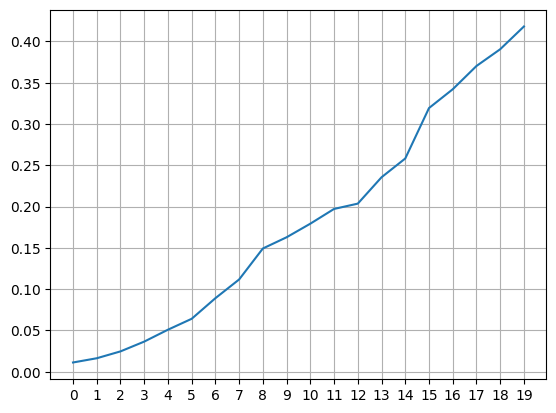

20

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
avgTotal=[]
for j in range(20):
  avgPerPos=[]
  for i in range(len(ProbabilityOverGames)):
    avgPerPos.append(ProbabilityOverGames[i][j])
  avgTotal.append(sum(avgPerPos)/len(avgPerPos))
print(avgTotal)
fig, ax = plt.subplots()
ax.plot(range(0,20), avgTotal)
"""for i in range(len(ProbabilityOverGames)):
  ax.plot( range(0,20),ProbabilityOverGames[i], label = f"Number {i}")"""
plt.xticks(range(0,20))
#plt.legend()
#ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#      title='About as simple as it gets, folks')
ax.grid()

plt.show()
len(probability)

In [ ]:
#This is the CHUNK BOT
#without printing results
#interesting experiment:
from random import randint
import random
import math
import time
itterations = 20
patternsIt = 0
performances = []
lists = []
probabilitiesOverTime1=[]
wincount = 0
gamesplayed = 0
#wrongAnswersPerQuestion = 4
totalgames = 134
dictperform={}
Entropy=[]
"""Entrop_over_game = []
list_losses=[]
list_wins=[]"""


while patternsIt<itterations:
    answerPattern=[True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True]
    answerPattern[patternsIt] = False
    #answerPattern[patternsIt+1] = False
    #answerPattern[patternsIt+2] = False
    #answerPattern[patternsIt+3] = False
    #answerPattern[patternsIt+4] = False
    #answerPattern[patternsIt+5] = False
    initilaizeCount=0
    wincount = 0
    gamesplayed = 0
    #answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
    popularEntities =  popentities("\n".join(PosAttr),"")
    patternsIt+=1

    while gamesplayed < totalgames:
        probabilities=[]
        Entropies=[]
        AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
        # Resets all variables
        i=0
        outofguess = []
        # pick subject
        #subject = pickSubject(qres)
        subject, attribu = allSubjects(qres, gamesplayed)
        #print("\n" , subject)
        Distribution = prepareProps(popularEntities)

        while i < 20:
            indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
            Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
            i+=1
            Entropies.append(Entropy)
            probabilities.append(Distribution[subject])
        highProb=-1
        for j in Distribution.values():
            if j > highProb:
                highProb=j
        answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
        #print("The Answer is: ", answer, "With a Probability of: ", highProb)
        #print(subject)
        if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
            wincount +=1
        #else:
            #print(subject, gamesplayed, probability, patternsIt)
            #list_wins.append(answerPattern)
        #else:

            #list_losses.append(answerPattern)
        gamesplayed+=1
        probabilitiesOverTime1.append(probabilities)
        #time.sleep(0.5)
    lists.append(answerPattern)
    performances.append(wincount)
    dictperform[wincount] =answerPattern
    #print("\nTournament ended! I have guessed " + str(wincount) + " out of " + str(gamesplayed) + " things correctly.")

itterations = 19
patternsIt = 0
performances1 = []
lists = []
probabilitiesOverTime2=[]
wincount = 0
gamesplayed = 0
#wrongAnswersPerQuestion = 4
totalgames = 134
dictperform={}
Entropy=[]
"""Entrop_over_game = []
list_losses=[]
list_wins=[]"""


while patternsIt<itterations:
    answerPattern=[True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True]
    answerPattern[patternsIt] = False
    answerPattern[patternsIt+1] = False
    #answerPattern[patternsIt+2] = False
    #answerPattern[patternsIt+3] = False
    #answerPattern[patternsIt+4] = False
    #answerPattern[patternsIt+5] = False
    initilaizeCount=0
    wincount = 0
    gamesplayed = 0
    #answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
    popularEntities =  popentities("\n".join(PosAttr),"")
    patternsIt+=1

    while gamesplayed < totalgames:
        probabilities=[]
        Entropies=[]
        AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
        # Resets all variables
        i=0
        outofguess = []
        # pick subject
        #subject = pickSubject(qres)
        subject, attribu = allSubjects(qres, gamesplayed)
        #print("\n" , subject)
        Distribution = prepareProps(popularEntities)

        while i < 20:
            indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
            Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
            i+=1
            Entropies.append(Entropy)
            probabilities.append(Distribution[subject])
        highProb=-1
        for j in Distribution.values():
            if j > highProb:
                highProb=j
        answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
        #print("The Answer is: ", answer, "With a Probability of: ", highProb)
        #print(subject)
        if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
            wincount +=1
        #else:
            #print(subject, gamesplayed, probability, patternsIt)
            #list_wins.append(answerPattern)
        #else:

            #list_losses.append(answerPattern)
        gamesplayed+=1
        probabilitiesOverTime2.append(probabilities)
        #time.sleep(0.5)
    lists.append(answerPattern)
    performances.append(wincount)
    dictperform[wincount] =answerPattern

itterations = 18
patternsIt = 0
probabilitiesOverTime3=[]
wincount = 0
gamesplayed = 0



while patternsIt<itterations:
    answerPattern=[True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True]
    answerPattern[patternsIt] = False
    answerPattern[patternsIt+1] = False
    answerPattern[patternsIt+2] = False
    #answerPattern[patternsIt+3] = False
    #answerPattern[patternsIt+4] = False
    #answerPattern[patternsIt+5] = False
    initilaizeCount=0
    wincount = 0
    gamesplayed = 0
    #answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
    popularEntities =  popentities("\n".join(PosAttr),"")
    patternsIt+=1

    while gamesplayed < totalgames:
        probabilities=[]
        Entropies=[]
        AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
        # Resets all variables
        i=0
        outofguess = []
        # pick subject
        #subject = pickSubject(qres)
        subject, attribu = allSubjects(qres, gamesplayed)
        #print("\n" , subject)
        Distribution = prepareProps(popularEntities)

        while i < 20:
            indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
            Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
            i+=1
            Entropies.append(Entropy)
            probabilities.append(Distribution[subject])
        highProb=-1
        for j in Distribution.values():
            if j > highProb:
                highProb=j
        answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
        #print("The Answer is: ", answer, "With a Probability of: ", highProb)
        #print(subject)
        if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
            wincount +=1
        #else:
            #print(subject, gamesplayed, probability, patternsIt)
            #list_wins.append(answerPattern)
        #else:


            #list_losses.append(answerPattern)
        gamesplayed+=1
        probabilitiesOverTime3.append(probabilities)
        #time.sleep(0.5)
    lists.append(answerPattern)
    performances.append(wincount)
    dictperform[wincount] =answerPattern

itterations = 17
patternsIt = 0
probabilitiesOverTime4=[]
wincount = 0
gamesplayed = 0



while patternsIt<itterations:
    answerPattern=[True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True]
    answerPattern[patternsIt] = False
    answerPattern[patternsIt+1] = False
    answerPattern[patternsIt+2] = False
    answerPattern[patternsIt+3] = False
    #answerPattern[patternsIt+4] = False
    #answerPattern[patternsIt+5] = False
    initilaizeCount=0
    wincount = 0
    gamesplayed = 0
    #answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
    popularEntities =  popentities("\n".join(PosAttr),"")
    patternsIt+=1

    while gamesplayed < totalgames:
        probabilities=[]
        Entropies=[]
        AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
        # Resets all variables
        i=0
        outofguess = []
        # pick subject
        #subject = pickSubject(qres)
        subject, attribu = allSubjects(qres, gamesplayed)
        #print("\n" , subject)
        Distribution = prepareProps(popularEntities)

        while i < 20:
            indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
            Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
            i+=1
            Entropies.append(Entropy)
            probabilities.append(Distribution[subject])
        highProb=-1
        for j in Distribution.values():
            if j > highProb:
                highProb=j
        answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
        #print("The Answer is: ", answer, "With a Probability of: ", highProb)
        #print(subject)
        if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
            wincount +=1
        #else:
            #print(subject, gamesplayed, probability, patternsIt)
            #list_wins.append(answerPattern)
        #else:

            #list_losses.append(answerPattern)
        gamesplayed+=1
        probabilitiesOverTime4.append(probabilities)
        #time.sleep(0.5)
    lists.append(answerPattern)
    performances.append(wincount)
    dictperform[wincount] =answerPattern


probabilitiesOverTime5=[]
wincount = 0
gamesplayed = 0
itterations=16
patternsIt=0

while patternsIt<itterations:
    answerPattern=[True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True]
    answerPattern[patternsIt] = False
    answerPattern[patternsIt+1] = False
    answerPattern[patternsIt+2] = False
    answerPattern[patternsIt+3] = False
    answerPattern[patternsIt+4] = False
    #answerPattern[patternsIt+5] = False
    initilaizeCount=0
    wincount = 0
    gamesplayed = 0
    #answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
    popularEntities =  popentities("\n".join(PosAttr),"")
    patternsIt+=1

    while gamesplayed < totalgames:
        probabilities=[]
        Entropies=[]
        AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
        # Resets all variables
        i=0
        outofguess = []
        # pick subject
        #subject = pickSubject(qres)
        subject, attribu = allSubjects(qres, gamesplayed)
        #print("\n" , subject)
        Distribution = prepareProps(popularEntities)

        while i < 20:
            indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
            Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
            i+=1
            Entropies.append(Entropy)
            probabilities.append(Distribution[subject])
        highProb=-1
        for j in Distribution.values():
            if j > highProb:
                highProb=j
        answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
        #print("The Answer is: ", answer, "With a Probability of: ", highProb)
        #print(subject)
        if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
            wincount +=1
        #else:
            #print(subject, gamesplayed, probability, patternsIt)
            #list_wins.append(answerPattern)
        #else:

            #list_losses.append(answerPattern)
        gamesplayed+=1
        probabilitiesOverTime5.append(probabilities)
        #time.sleep(0.5)
    lists.append(answerPattern)
    performances.append(wincount)
    dictperform[wincount] =answerPattern



probabilitiesOverTime6=[]
wincount = 0
gamesplayed = 0
itterations=15
patternsIt=0


while patternsIt<itterations:
    answerPattern=[True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True]
    answerPattern[patternsIt] = False
    answerPattern[patternsIt+1] = False
    answerPattern[patternsIt+2] = False
    answerPattern[patternsIt+3] = False
    answerPattern[patternsIt+4] = False
    answerPattern[patternsIt+5] = False
    initilaizeCount=0
    wincount = 0
    gamesplayed = 0
    #answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
    popularEntities =  popentities("\n".join(PosAttr),"")
    patternsIt+=1

    while gamesplayed < totalgames:
        probabilities=[]
        Entropies=[]
        AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
        # Resets all variables
        i=0
        outofguess = []
        # pick subject
        #subject = pickSubject(qres)
        subject, attribu = allSubjects(qres, gamesplayed)
        #print("\n" , subject)
        Distribution = prepareProps(popularEntities)

        while i < 20:
            indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
            Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
            i+=1
            Entropies.append(Entropy)
            probabilities.append(Distribution[subject])
        highProb=-1
        for j in Distribution.values():
            if j > highProb:
                highProb=j
        answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
        #print("The Answer is: ", answer, "With a Probability of: ", highProb)
        #print(subject)
        if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
            wincount +=1
        #else:
            #print(subject, gamesplayed, probability, patternsIt)
            #list_wins.append(answerPattern)
        #else:

            #list_losses.append(answerPattern)
        gamesplayed+=1
        probabilitiesOverTime6.append(probabilities)
        #time.sleep(0.5)
    lists.append(answerPattern)
    performances.append(wincount)
    dictperform[wincount] =answerPattern

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Does the thing you are looking for have the attribute: hasOccupation Actor?
False
Does the thing you are looking for have the attribute: nationality United_States?
True
Does the thing you are looking for have the attribute: memberOf Democratic_Party_(United_States)?
True
Does the thing you are looking for have the attribute: hasOccupation Politician?
False
Does the thing you are looking for have the attribute: hasOccupation Film_producer?
False
Does the thing you are looking for have the attribute: hasOccupation Stage_actor?
True
Does the thing you are looking for have the attribute: alumniOf Lee_Strasberg_Theatre_and_Film_Institute?
True
Does the thing you are looking for have the attribute: 22-rdf-syntax-ns#type Twin?
True
Does the thing you are looking for have the attribute: alumniOf Professional_Children's_School?
True
Does the thing you are looking for have the attribute: award BAFTA_Award_for_Best_Actress_in_a_Le

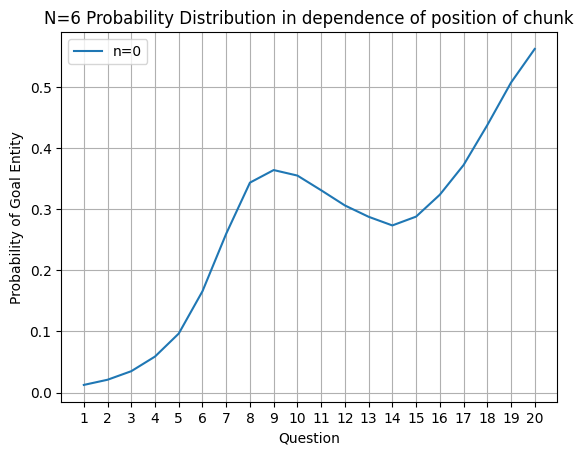

[0.010733653765072952, 0.01549347160059403, 0.02230000062062637, 0.032097127513973735, 0.04450571924451625, 0.0641163665050989, 0.09135526862623994, 0.10846715465943622, 0.10521935763747492, 0.09263312893545131, 0.0801147616552936, 0.06947128560705802, 0.06412477662043783, 0.0680321980152795, 0.08686495298455024, 0.1200622868255319, 0.16708667065587618, 0.2243651355412698, 0.2819153763252696, 0.3402032665458126]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
res=[]
totalAvg=[]
for k in range(15):
  avgTotal=[]
  for j in range(20):
    avgPerPos=[]
    for i in range(134):
      avgPerPos.append(probabilitiesOverTime[i*(k+1)][j])
    avgTotal.append(sum(avgPerPos)/len(avgPerPos))
  res.append(avgTotal)

avgRes=[]
for j in range(20):
  temp=[]
  for i in res:
    temp.append(i[j])
  avgRes.append(sum(temp)/len(temp))

fig, ax = plt.subplots()
#ax.plot(range(0,20), avgTotal)
for i in range((1)):
  ax.plot( range(1,21),res[i+14], label = f"n={i}")
plt.xticks(range(1,21))
plt.legend()
ax.set(xlabel='Question', ylabel='Probability of Goal Entity',
      title='N=6 Probability Distribution in dependence of position of chunk')
ax.grid()
#plt.savefig("ProbabilitiesForN6.png")
plt.show()
len(probability)
print(avgRes)
N6 = probabilitiesOverTime

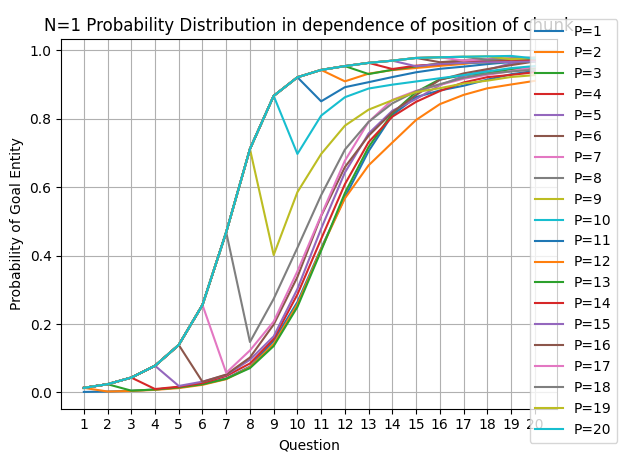

"\nfor i in range(20): \n  local=[]\n  for j in range(len(probabilitiesOverTime1)):\n    local.append(probabilitiesOverTime1[j][i])\n  avg1.append(sum(local)/len(local))\n\nfor i in range(20): \n  local=[]\n  for j in range(len(probabilitiesOverTime2)):\n    local.append(probabilitiesOverTime2[j][i])\n  avg2.append(sum(local)/len(local))\nfor i in range(20): \n  local=[]\n  for j in range(len(probabilitiesOverTime3)):\n    local.append(probabilitiesOverTime3[j][i])\n  avg3.append(sum(local)/len(local))\nfor i in range(20): \n  local=[]\n  for j in range(len(probabilitiesOverTime4)):\n    local.append(probabilitiesOverTime4[j][i])\n  avg4.append(sum(local)/len(local))\nfor i in range(20): \n  local=[]\n  for j in range(len(probabilitiesOverTime5)):\n    local.append(probabilitiesOverTime5[j][i])\n  avg5.append(sum(local)/len(local))\nfor i in range(20): \n  local=[]\n  for j in range(len(probabilitiesOverTime6)):\n    local.append(probabilitiesOverTime6[j][i])\n  avg6.append(sum(local)/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
res=[]
totalAvg=[]
for k in range(20):
  avgTotal=[]
  for j in range(20):
    avgPerPos=[]
    for i in range(134):
      startingPos=k*134
      avgPerPos.append(probabilitiesOverTime1[i+startingPos][j])
    avgTotal.append(sum(avgPerPos)/len(avgPerPos))
  res.append(avgTotal)



avgRes=[]
fig, ax = plt.subplots()
#ax.plot(range(0,20), avgTotal)
for i in range((20)):
  ax.plot(range(1,21),res[i], label = f"P={i+1}")
plt.xticks(range(1,21))
#ax.legend(bbox_to_anchor=(1.05, 1))
fig.legend(loc='outside right')
ax.set(xlabel='Question', ylabel='Probability of Goal Entity',
      title='N=1 Probability Distribution in dependence of position of chunk')
ax.grid()
plt.savefig("ProbabilitiesForN1.png")

#plt.savefig("ProbabilitiesForN2.png")
plt.show()
avg1=[]
avg2=[]
avg3=[]
avg4=[]
avg5=[]
avg6=[]
"""
for i in range(20):
  local=[]
  for j in range(len(probabilitiesOverTime1)):
    local.append(probabilitiesOverTime1[j][i])
  avg1.append(sum(local)/len(local))

for i in range(20):
  local=[]
  for j in range(len(probabilitiesOverTime2)):
    local.append(probabilitiesOverTime2[j][i])
  avg2.append(sum(local)/len(local))
for i in range(20):
  local=[]
  for j in range(len(probabilitiesOverTime3)):
    local.append(probabilitiesOverTime3[j][i])
  avg3.append(sum(local)/len(local))
for i in range(20):
  local=[]
  for j in range(len(probabilitiesOverTime4)):
    local.append(probabilitiesOverTime4[j][i])
  avg4.append(sum(local)/len(local))
for i in range(20):
  local=[]
  for j in range(len(probabilitiesOverTime5)):
    local.append(probabilitiesOverTime5[j][i])
  avg5.append(sum(local)/len(local))
for i in range(20):
  local=[]
  for j in range(len(probabilitiesOverTime6)):
    local.append(probabilitiesOverTime6[j][i])
  avg6.append(sum(local)/len(local))

print(f'avgProbN1 = {avg1}')
print(f'avgProbN2 = {avg2}')
print(f'avgProbN3 = {avg3}')
print(f'avgProbN4 = {avg4}')
print(f'avgProbN5 = {avg5}')
print(f'avgProbN6 = {avg6}')
"""


In [ ]:
#without printing results
#interesting experiment:
from random import randint
import random
import math
import time
performances = []
lists = []
wincount = 0
gamesplayed = 0
wrongAnswersPerQuestion = 1
between=1
tempwins=0
totalgames = 1340
probability1=[]
dictperform={}

"""Entrop_over_game = []
list_losses=[]
list_wins=[]"""



while gamesplayed < totalgames:
  probs=[]
  Entropies=[]
  AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
  # Resets all variables
  i=0
  outofguess = []
  # pick subject
  #subject = pickSubject(qres)
  answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
  subject, attribu = allSubjects(qres, gamesplayed%134)

  Distribution = prepareProps(popularEntities)
  while i < 20:
    indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
    Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
    i+=1
    Entropies.append(Entropy)
    probs.append(Distribution[subject])
  highProb=-1
  for j in Distribution.values():
      if j > highProb:
          highProb=j
  answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
  #print(subject, answer)
  #print("The Answer is: ", answer, "With a Probability of: ", highProb)
  #print(subject)
  if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
      wincount +=1
      tempwins+=1
  gamesplayed+=1
  probability1.append(probs)
  if gamesplayed/134>=between:
    between+=1
    print(tempwins , ",")
    tempwins=0
  #time.sleep(0.5)
#lists.append(answerPattern)
#performances.append(wincount)
#dictperform[wincount] =answerPattern
print("\nTournament ended! I have guessed " + str(wincount) + " out of " + str(gamesplayed) + " things correctly.")


performances = []
lists = []
wincount = 0
gamesplayed = 0
wrongAnswersPerQuestion = 2
between=1
tempwins=0
totalgames = 1340
probability2=[]
dictperform={}

"""Entrop_over_game = []
list_losses=[]
list_wins=[]"""



while gamesplayed < totalgames:
  probs=[]
  Entropies=[]
  AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
  # Resets all variables
  i=0
  outofguess = []
  # pick subject
  #subject = pickSubject(qres)
  answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
  subject, attribu = allSubjects(qres, gamesplayed%134)

  Distribution = prepareProps(popularEntities)
  while i < 20:
    indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
    Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
    i+=1
    Entropies.append(Entropy)
    probs.append(Distribution[subject])
  highProb=-1
  for j in Distribution.values():
      if j > highProb:
          highProb=j
  answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
  #print(subject, answer)
  #print("The Answer is: ", answer, "With a Probability of: ", highProb)
  #print(subject)
  if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
      wincount +=1
      tempwins+=1
  gamesplayed+=1
  probability2.append(probs)
  if gamesplayed/134>=between:
    between+=1
    print(tempwins , ",")
    tempwins=0
  #time.sleep(0.5)
#lists.append(answerPattern)
#performances.append(wincount)
#dictperform[wincount] =answerPattern
print("\nTournament ended! I have guessed " + str(wincount) + " out of " + str(gamesplayed) + " things correctly.")

performances = []
lists = []
wincount = 0
gamesplayed = 0
wrongAnswersPerQuestion = 3
between=1
tempwins=0
totalgames = 1340
probability3=[]
dictperform={}

"""Entrop_over_game = []
list_losses=[]
list_wins=[]"""



while gamesplayed < totalgames:
  probs=[]
  Entropies=[]
  AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
  # Resets all variables
  i=0
  outofguess = []
  # pick subject
  #subject = pickSubject(qres)
  answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
  subject, attribu = allSubjects(qres, gamesplayed%134)

  Distribution = prepareProps(popularEntities)
  while i < 20:
    indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
    Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
    i+=1
    Entropies.append(Entropy)
    probs.append(Distribution[subject])
  highProb=-1
  for j in Distribution.values():
      if j > highProb:
          highProb=j
  answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
  #print(subject, answer)
  #print("The Answer is: ", answer, "With a Probability of: ", highProb)
  #print(subject)
  if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
      wincount +=1
      tempwins+=1
  gamesplayed+=1
  probability3.append(probs)
  if gamesplayed/134>=between:
    between+=1
    print(tempwins , ",")
    tempwins=0
  #time.sleep(0.5)
#lists.append(answerPattern)
#performances.append(wincount)
#dictperform[wincount] =answerPattern
print("\nTournament ended! I have guessed " + str(wincount) + " out of " + str(gamesplayed) + " things correctly.")


performances = []
lists = []
wincount = 0
gamesplayed = 0
wrongAnswersPerQuestion = 4
between=1
tempwins=0
totalgames = 1340
probability4=[]
dictperform={}

"""Entrop_over_game = []
list_losses=[]
list_wins=[]"""



while gamesplayed < totalgames:
  probs=[]
  Entropies=[]
  AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
  # Resets all variables
  i=0
  outofguess = []
  # pick subject
  #subject = pickSubject(qres)
  answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
  subject, attribu = allSubjects(qres, gamesplayed%134)

  Distribution = prepareProps(popularEntities)
  while i < 20:
    indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
    Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
    i+=1
    Entropies.append(Entropy)
    probs.append(Distribution[subject])
  highProb=-1
  for j in Distribution.values():
      if j > highProb:
          highProb=j
  answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
  #print(subject, answer)
  #print("The Answer is: ", answer, "With a Probability of: ", highProb)
  #print(subject)
  if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
      wincount +=1
      tempwins+=1
  gamesplayed+=1
  probability4.append(probs)
  if gamesplayed/134>=between:
    between+=1
    print(tempwins , ",")
    tempwins=0
  #time.sleep(0.5)
#lists.append(answerPattern)
#performances.append(wincount)
#dictperform[wincount] =answerPattern
print("\nTournament ended! I have guessed " + str(wincount) + " out of " + str(gamesplayed) + " things correctly.")


performances = []
lists = []
wincount = 0
gamesplayed = 0
wrongAnswersPerQuestion = 5
between=1
tempwins=0
totalgames = 1340
probability5=[]
dictperform={}

"""Entrop_over_game = []
list_losses=[]
list_wins=[]"""



while gamesplayed < totalgames:
  probs=[]
  Entropies=[]
  AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
  # Resets all variables
  i=0
  outofguess = []
  # pick subject
  #subject = pickSubject(qres)
  answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
  subject, attribu = allSubjects(qres, gamesplayed%134)

  Distribution = prepareProps(popularEntities)
  while i < 20:
    indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
    Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
    i+=1
    Entropies.append(Entropy)
    probs.append(Distribution[subject])
  highProb=-1
  for j in Distribution.values():
      if j > highProb:
          highProb=j
  answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
  #print(subject, answer)
  #print("The Answer is: ", answer, "With a Probability of: ", highProb)
  #print(subject)
  if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
      wincount +=1
      tempwins+=1
  gamesplayed+=1
  probability5.append(probs)
  if gamesplayed/134>=between:
    between+=1
    print(tempwins , ",")
    tempwins=0
  #time.sleep(0.5)
#lists.append(answerPattern)
#performances.append(wincount)
#dictperform[wincount] =answerPattern
print("\nTournament ended! I have guessed " + str(wincount) + " out of " + str(gamesplayed) + " things correctly.")


performances = []
lists = []
wincount = 0
gamesplayed = 0
wrongAnswersPerQuestion = 6
between=1
tempwins=0
totalgames = 1340
probability6=[]
dictperform={}

"""Entrop_over_game = []
list_losses=[]
list_wins=[]"""



while gamesplayed < totalgames:
  probs=[]
  Entropies=[]
  AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
  # Resets all variables
  i=0
  outofguess = []
  # pick subject
  #subject = pickSubject(qres)
  answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
  subject, attribu = allSubjects(qres, gamesplayed%134)

  Distribution = prepareProps(popularEntities)
  while i < 20:
    indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
    Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
    i+=1
    Entropies.append(Entropy)
    probs.append(Distribution[subject])
  highProb=-1
  for j in Distribution.values():
      if j > highProb:
          highProb=j
  answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
  #print(subject, answer)
  #print("The Answer is: ", answer, "With a Probability of: ", highProb)
  #print(subject)
  if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
      wincount +=1
      tempwins+=1
  gamesplayed+=1
  probability6.append(probs)
  if gamesplayed/134>=between:
    between+=1
    print(tempwins , ",")
    tempwins=0
  #time.sleep(0.5)
#lists.append(answerPattern)
#performances.append(wincount)
#dictperform[wincount] =answerPattern
print("\nTournament ended! I have guessed " + str(wincount) + " out of " + str(gamesplayed) + " things correctly.")



Streaming output truncated to the last 5000 lines.
True
Does the thing you are looking for have the attribute: memberOf Democratic_Party_(United_States)?
True
Does the thing you are looking for have the attribute: hasOccupation Politician?
False
Does the thing you are looking for have the attribute: hasOccupation Film_producer?
False
Does the thing you are looking for have the attribute: hasOccupation Stage_actor?
True
Does the thing you are looking for have the attribute: alumniOf Lee_Strasberg_Theatre_and_Film_Institute?
False
Does the thing you are looking for have the attribute: birthPlace Los_Angeles?
True
Does the thing you are looking for have the attribute: award British_Academy_of_Film_and_Television_Arts?
False
Does the thing you are looking for have the attribute: homeLocation Los_Angeles?
False
Does the thing you are looking for have the attribute: alumniOf Columbia_University?
False
Does the thing you are looking for have the attribute: knowsLanguage English_language?
True

In [ ]:
#This is the RELEVANCE BOT
#without printing results
#interesting experiment:
from random import randint
import random
import math
import time
resultsX=[]
itterations = 20
patternsIt = 0
performances = []
lists = []
wincount = 0
gamesplayed = 0
wrongAnswersPerQuestion = 6
totalgames = 134
dictperform={}
Entropy=[]
"""Entrop_over_game = []
list_losses=[]
list_wins=[]"""


while patternsIt<itterations:
    answerPattern, initilaizeCount = wrongAnswerListPlusOne(wrongAnswersPerQuestion-1, patternsIt)
    #answerPattern[patternsIt+1] = False
    #answerPattern[patternsIt+2] = False
    #answerPattern[patternsIt+3] = False
    #answerPattern[patternsIt+4] = False
    #answerPattern[patternsIt+5] = False
    initilaizeCount=0
    wincount = 0
    gamesplayed = 0
    #answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
    popularEntities =  popentities("\n".join(PosAttr),"")
    patternsIt+=1

    while gamesplayed < totalgames:
        answerPattern, initilaizeCount = wrongAnswerListPlusOne(wrongAnswersPerQuestion-1, patternsIt-1)
        Entropies=[]
        AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
        # Resets all variables
        i=0
        outofguess = []
        # pick subject
        #subject = pickSubject(qres)
        subject, attribu = allSubjects(qres, gamesplayed)
        #print("\n" , subject)
        Distribution = prepareProps(popularEntities)

        while i < 20:
            indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
            Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu, pos, negs)
            i+=1
            Entropies.append(Entropy)
        highProb=-1
        for j in Distribution.values():
            if j > highProb:
                highProb=j
        answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
        #print("The Answer is: ", answer, "With a Probability of: ", highProb)
        #print(subject)
        if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
            wincount +=1
            #list_wins.append(answerPattern)
        #else:

            #list_losses.append(answerPattern)
        gamesplayed+=1
        #time.sleep(0.5)
    lists.append(answerPattern)
    performances.append(wincount)
    dictperform[wincount] =answerPattern
    #print("\nTournament ended! I have guessed " + str(wincount) + " out of " + str(gamesplayed) + " things correctly.")
    print(wincount, ",")
    resultsX.append([wincount, patternsIt])

1 ,
2 ,
4 ,
5 ,
2 ,
3 ,
4 ,
6 ,
5 ,
4 ,
7 ,
5 ,
8 ,
5 ,
10 ,
5 ,
2 ,
6 ,
4 ,
9 ,


In [ ]:
from random import randint
import random
import math
import time

possibleObj, possiblePred, count = findSplits()
popularEntities =  popentities("\n".join(PosAttr),"")
Distribution = prepareProps(popularEntities)


bestSplit=-1
indexBestSplit = -1
#branches = range(2,250)
#for i in random.sample(branches, 30):
for i in range(25):
    #Fix The nummerical thing here::: (skip over i if nummer)
    if str('<' + str(possiblePred[i]) +'> <'+str(possibleObj[i])+ '>') in AttrHistory:
        continue
    else:
        Yes, No = findPosAndNeg(possibleObj, possiblePred, i)
        OccurenceYes=len(Yes)
        OccurenceNo=len(No)
        WeightYes=0
        WeightNo=0
        for y in Yes:
            WeightYes+=Distribution[y]
        for n in No:
            WeightNo+=Distribution[n]
        SumWeights=WeightYes+WeightNo
        ProbabilityYes=WeightYes/SumWeights
        ProbabilityNo=WeightNo/SumWeights
        Entropy = - (ProbabilityYes * math.log(ProbabilityYes+0.0001,2) + ProbabilityNo * math.log(ProbabilityNo+0.0001,2))
        #print(Entropy, possiblePred[i], possibleObj[i])
        #print(str(possiblePred[i]) +'> <'+str(possibleObj[i]), Entropy)
        if Entropy > bestSplit:
            bestSplit=Entropy
            indexBestSplit=i
#print(bestSplit, possibleObj[indexBestSplit], possiblePred[indexBestSplit])
print(bestSplit, indexBestSplit)

[0.012792107260308926, 0.021971544135450098, 0.03765237323543848, 0.06409128906577106, 0.10803166964119432, 0.18708259142344574, 0.32083471166834626, 0.46554434010489176, 0.568161047386309, 0.6483874324954035, 0.7315441669776469, 0.8044534974679657, 0.8566012659259387, 0.891336127589352, 0.9146912857309283, 0.9301507434112195, 0.9403992164685209, 0.9480239089776299, 0.9543832078108744, 0.9589224795669546]


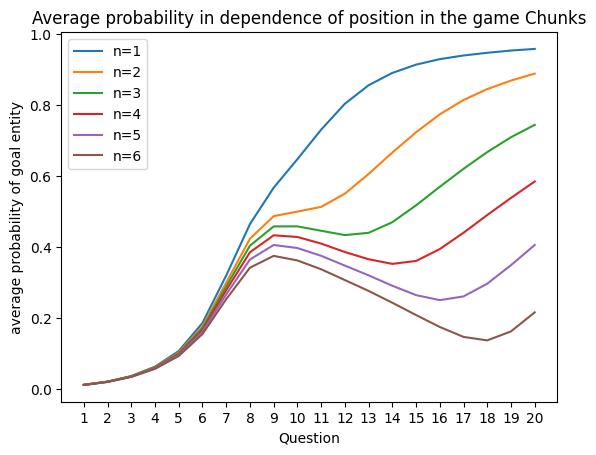

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
res1=[]
for j in range(20):
  pr=[]
  for i in probabilitiesOverTime1:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res1.append(pr)

res2=[]
for j in range(20):
  pr=[]
  for i in probabilitiesOverTime2:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res2.append(pr)

res3=[]
for j in range(20):
  pr=[]
  for i in probabilitiesOverTime3:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res3.append(pr)

res4=[]
for j in range(20):
  pr=[]
  for i in probabilitiesOverTime4:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res4.append(pr)

res5=[]
for j in range(20):
  pr=[]
  for i in probabilitiesOverTime5:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res5.append(pr)

res6=[]
for j in range(20):
  pr=[]
  for i in probabilitiesOverTime6:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res6.append(pr)


fig, ax = plt.subplots()
ax.set(xlabel='Question', ylabel ='average probability of goal entity', title='Average probability in dependence of position in the game Chunks')
plt.plot(range(1,21),res1, label = "n=1")
plt.plot(range(1,21),res2, label = "n=2")
plt.plot(range(1,21),res3, label = "n=3")
plt.plot(range(1,21),res4, label = "n=4")
plt.plot(range(1,21),res5, label = "n=5")
plt.plot(range(1,21),res6, label = "n=6")
plt.legend()
plt.xticks(range(1,21))
plt.savefig("avgProbChunk.png")
avg1=[]
for i in range(20):
  avg1.append((res1[i] + res2[i] +res3[i] +res4[i]+ res5[i]+ res6[i])/6)
print(res1)

In [ ]:
import random
l = []
i = -1
for i in range(19-3):
    l.append(True)
for i in range(3):
    l.append(False)
random.shuffle(l)
l.insert(3, False)
print(l)

[True, False, True, False, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True]


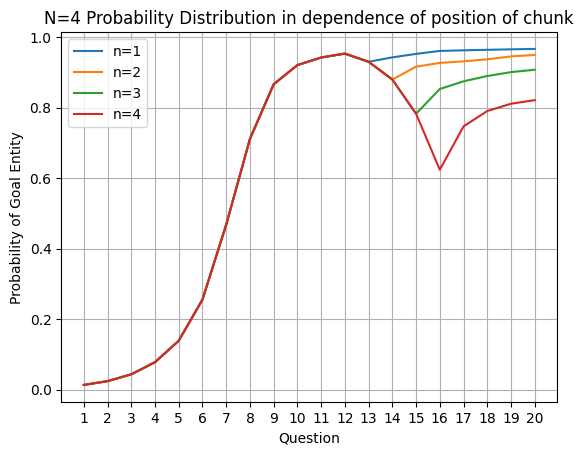

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
res1=[]
#for k in range(1):
k=12
avgTotal1=[]
avgTotal2=[]
avgTotal3=[]
avgTotal4=[]
avgTotal5=[]
avgTotal6=[]

for j in range(20):
  avgPerPos1=[]
  avgPerPos2=[]
  avgPerPos3=[]
  avgPerPos4=[]
  avgPerPos5=[]
  avgPerPos6=[]
  for i in range(134):
    startingPos=k*134
    avgPerPos1.append(probabilitiesOverTime1[startingPos+i][j])
    avgPerPos2.append(probabilitiesOverTime2[startingPos+i][j])
    avgPerPos3.append(probabilitiesOverTime3[startingPos+i][j])
    avgPerPos4.append(probabilitiesOverTime4[startingPos+i][j])
    avgPerPos5.append(probabilitiesOverTime5[i*(k+1)][j])
    avgPerPos6.append(probabilitiesOverTime6[i*(k+1)][j])
  avgTotal1.append(sum(avgPerPos1)/len(avgPerPos1))
  avgTotal2.append(sum(avgPerPos2)/len(avgPerPos2))
  avgTotal3.append(sum(avgPerPos3)/len(avgPerPos3))
  avgTotal4.append(sum(avgPerPos4)/len(avgPerPos4))
  avgTotal5.append(sum(avgPerPos5)/len(avgPerPos5))
  avgTotal6.append(sum(avgPerPos6)/len(avgPerPos6))


fig, ax = plt.subplots()
#ax.plot(range(0,20), avgTotal)
ax.plot( range(1,21),avgTotal1, label = f"n={1}")
ax.plot( range(1,21),avgTotal2, label = f"n={2}")
ax.plot( range(1,21),avgTotal3, label = f"n={3}")
ax.plot( range(1,21),avgTotal4, label = f"n={4}")
plt.xticks(range(1,21))
plt.legend()
ax.set(xlabel='Question', ylabel='Probability of Goal Entity',
      title='N=4 Probability Distribution in dependence of position of chunk')
ax.grid()

#plt.savefig("ProbabilitiesForN4.png")
plt.show()


In [ ]:
patternsIt=0
answerPattern=[True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True]
answerPattern[patternsIt] = False
answerPattern[patternsIt+1] = False
answerPattern[patternsIt+2] = False
answerPattern[patternsIt+3] = False
answerPattern[patternsIt+4] = False
answerPattern[patternsIt+5] = False
print(answerPattern)

[False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [ ]:
avg1=[]
for i in range(20):
  local=[]
  for j in range(len(probabilitiesOverTime1)):
    local.append(probabilitiesOverTime1[j][i])
  avg1.append(sum(local)/len(local))
print((avg1))

diff=[]
for j in range(20):
  value =probabilitiesOverTime1[j*134:(j*134)+134]
  diff.append(sum(value[0])/(len(value)))
print(diff)

NameError: ignored

[0.011343306068527579, 0.01717684480680996, 0.026337973074462145, 0.04036675984316456, 0.06096209762877133, 0.09372293176013487, 0.14295777190698286, 0.19469876677429768, 0.2329596938003856, 0.26991260552793056, 0.3084810542317585, 0.3426327378700938, 0.3757120205975504, 0.40247508572942176, 0.4282728058028918, 0.45197184748808517, 0.4763540493111003, 0.49676584032269555, 0.5148369227615959, 0.5308484776187231]


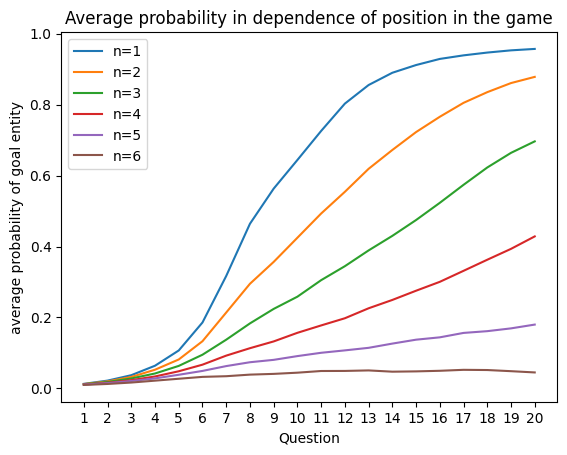

In [ ]:
res1=[]
for j in range(20):
  pr=[]
  for i in probability1:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res1.append(pr)

res2=[]
for j in range(20):
  pr=[]
  for i in probability2:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res2.append(pr)

res3=[]
for j in range(20):
  pr=[]
  for i in probability3:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res3.append(pr)

res4=[]
for j in range(20):
  pr=[]
  for i in probability4:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res4.append(pr)

res5=[]
for j in range(20):
  pr=[]
  for i in probability5:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res5.append(pr)

res6=[]
for j in range(20):
  pr=[]
  for i in probability6:
    pr.append(i[j])
  pr = sum(pr)/len(pr)
  res6.append(pr)


fig, ax = plt.subplots()
ax.set(xlabel='Question', ylabel ='average probability of goal entity', title='Average probability in dependence of position in the game')
plt.plot(range(1,21),res1, label = "n=1")
plt.plot(range(1,21),res2, label = "n=2")
plt.plot(range(1,21),res3, label = "n=3")
plt.plot(range(1,21),res4, label = "n=4")
plt.plot(range(1,21),res5, label = "n=5")
plt.plot(range(1,21),res6, label = "n=6")
plt.legend()
plt.xticks(range(1,21))
plt.savefig("avgProbRand.png")
avg1=[]
for i in range(20):
  avg1.append((res1[i] + res2[i] +res3[i] +res4[i]+ res5[i]+ res6[i])/6)
print(avg1)